In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use("ggplot")
import warnings
warnings.filterwarnings("ignore")

In [51]:
data_orders=pd.read_csv("data_orders.csv")

In [52]:
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [53]:
data_offers=pd.read_csv("data_offers.csv")

In [54]:
data_offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


## Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

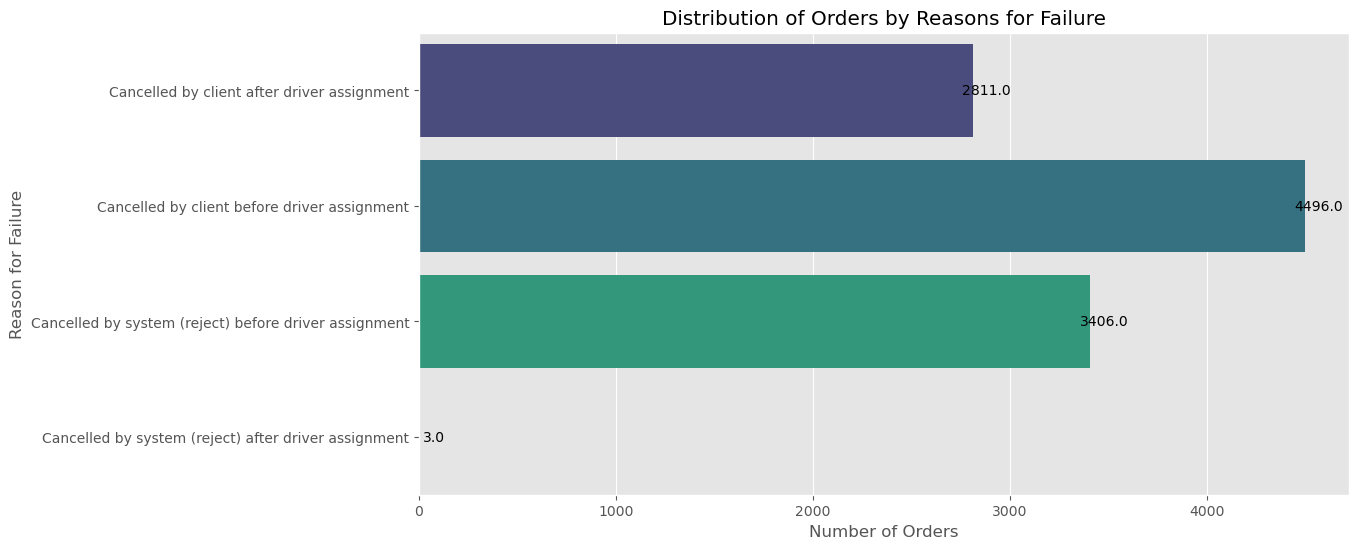

In [78]:
# Categorize the reasons for failure
def categorize_failure(row):
    if row['order_status_key'] == 4:
        if row['is_driver_assigned_key'] == 1:
            return 'Cancelled by client after driver assignment'
        else:
            return 'Cancelled by client before driver assignment'
    elif row['order_status_key'] == 9:
        if row['is_driver_assigned_key'] == 1:
            return 'Cancelled by system (reject) after driver assignment'
        else:
            return 'Cancelled by system (reject) before driver assignment'
    return 'Other'

data_orders['failure_reason'] = data_orders.apply(categorize_failure, axis=1)

# Plot the distribution of orders by failure reasons
plt.figure(figsize=(12, 6))
ax=sns.countplot(data=data_orders, y='failure_reason', palette='viridis')
# Annotate each bar with the count
for p in ax.patches:
    width = p.get_width()  # the width of each bar
    ax.annotate(f'{width}', 
                (width, p.get_y() + p.get_height() / 2), 
                ha='center', va='center', 
                xytext=(10, 0), 
                textcoords='offset points')

plt.title('Distribution of Orders by Reasons for Failure')
plt.ylabel('Reason for Failure')
plt.xlabel('Number of Orders')
plt.show()

* Most of the cancellation has been done before driver have been assigned.
* In both cases the cancellation by client is higher.
* Once the driver is assigned the cancellation by the system is very low.
* We can say that after the driver has been assigned cancellation is mostly done by the clients.

## Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

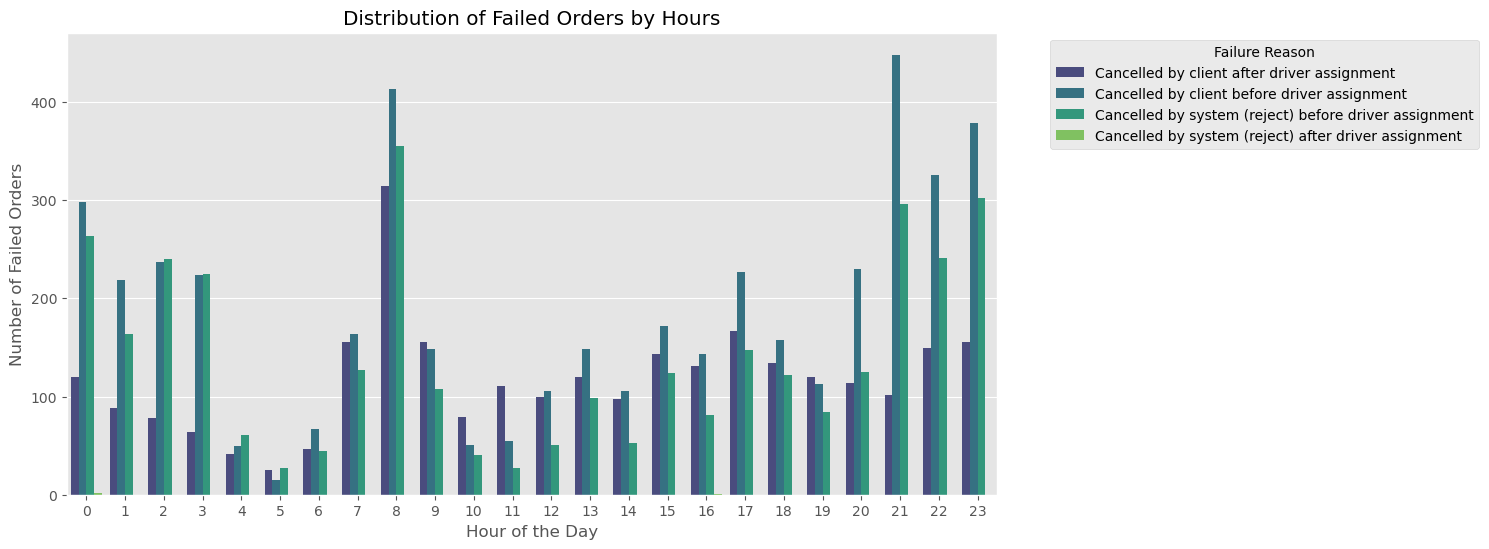

In [90]:
# Extract the hour from order_datetime
data_orders['order_datetime'] = pd.to_datetime(data_orders['order_datetime'], format='%H:%M:%S')
data_orders['hour'] = data_orders['order_datetime'].dt.hour

# Plot the distribution of failed orders by hours
plt.figure(figsize=(12, 6))
sns.countplot(data=data_orders, x='hour', hue='failure_reason', palette='viridis')
plt.title('Distribution of Failed Orders by Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Failed Orders')
plt.legend(title='Failure Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

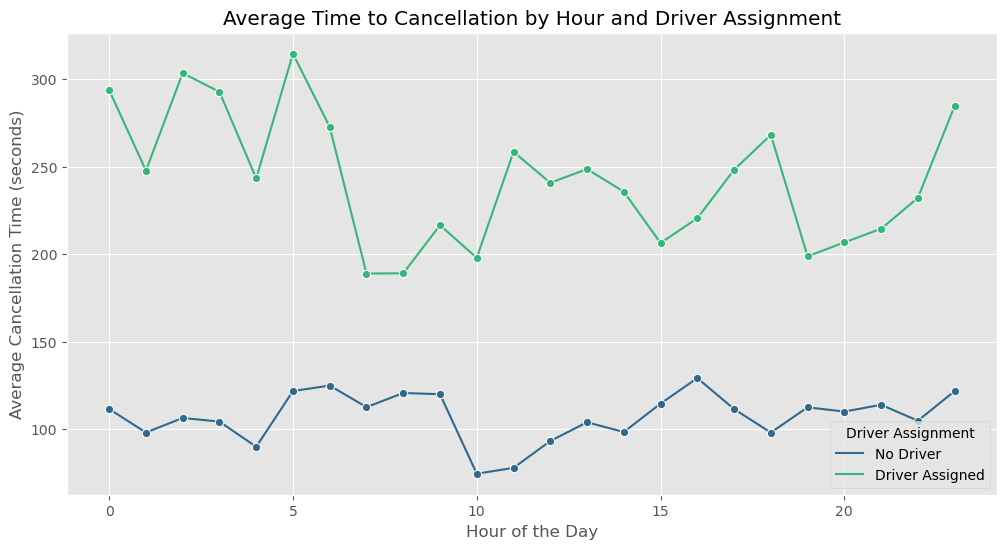

In [81]:
# Calculate average time to cancellation by hour and driver assignment
average_cancellation_time = data_orders.groupby(['hour', 'is_driver_assigned_key'])['cancellations_time_in_seconds'].mean().reset_index()

# Map driver assignment key to a more readable format
average_cancellation_time['driver_assigned'] = average_cancellation_time['is_driver_assigned_key'].map({0: 'No Driver', 1: 'Driver Assigned'})

# Plot the average cancellation time
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_cancellation_time, x='hour', y='cancellations_time_in_seconds', hue='driver_assigned', marker='o', palette='viridis')
plt.title('Average Time to Cancellation by Hour and Driver Assignment')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Cancellation Time (seconds)')
plt.legend(title='Driver Assignment')
plt.show()

## Plot the distribution of average ETA by hours. How can this plot be explained?

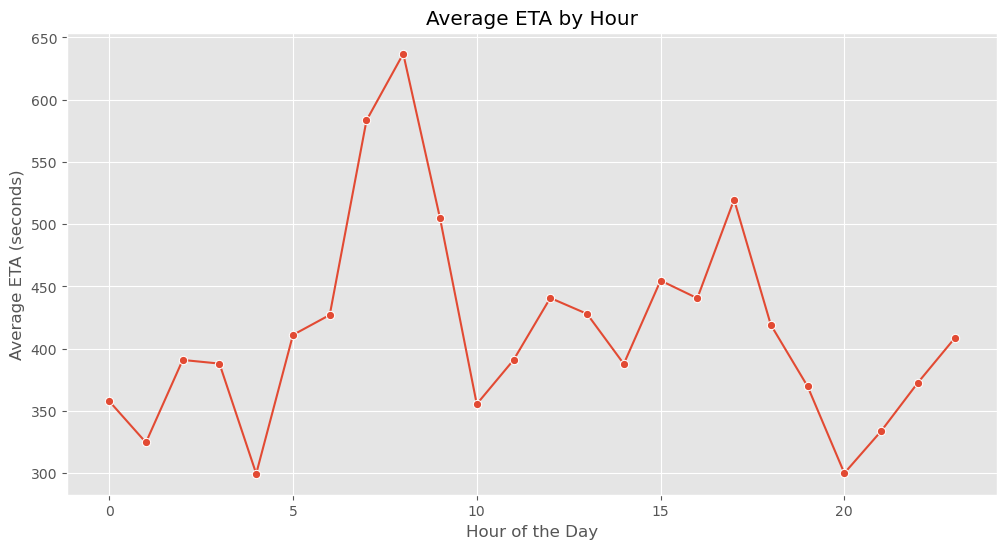

In [84]:
# Calculate average ETA by hour
average_eta = data_orders.groupby('hour')['m_order_eta'].mean().reset_index()

# Plot the average ETA by hour
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_eta, x='hour', y='m_order_eta', marker='o', palette='viridis')
plt.title('Average ETA by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA (seconds)')
plt.show()

## Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [86]:
!pip install h3 folium

  Obtaining dependency information for h3 from https://files.pythonhosted.org/packages/a2/db/efbcb0221919aa4a7c67277351689b064a8d7d1fb14ec1a5ccf873a485e1/h3-3.7.7-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for folium from https://files.pythonhosted.org/packages/b9/98/9ba4b9d2d07dd32765ddb4e4c189dcbdd7dca4d5a735e2e4ea756f40c36b/folium-0.16.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for branca>=0.6.0 from https://files.pythonhosted.org/packages/75/ca/6074ab4a04dd1a503201c18091b3426f3709670115fae316907a97f98d75/branca-0.7.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.4/984.4 kB 7.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 10.6 MB/s eta 0:00:00


In [87]:
import folium
import h3
from h3 import h3

# Define function to get H3 hexagon
def get_h3_hexagon(lat, lon, resolution=8):
    return h3.geo_to_h3(lat, lon, resolution)

# Add a column for hexagons
data_orders['h3_hex'] = data_orders.apply(lambda row: get_h3_hexagon(row['origin_latitude'], row['origin_longitude']), axis=1)

# Calculate the number of orders per hexagon
hex_counts = data_orders['h3_hex'].value_counts().reset_index()
hex_counts.columns = ['h3_hex', 'order_count']

# Calculate the cumulative distribution and find hexes that contain 80% of orders
hex_counts['cumulative_sum'] = hex_counts['order_count'].cumsum()
hex_counts['cumulative_perc'] = hex_counts['cumulative_sum'] / hex_counts['order_count'].sum()
hex_80_perc = hex_counts[hex_counts['cumulative_perc'] <= 0.8]

# Create a Folium map centered at the mean location
m = folium.Map(location=[data_orders['origin_latitude'].mean(), data_orders['origin_longitude'].mean()], zoom_start=12)

# Add hexagons to the map
for hexagon in hex_80_perc['h3_hex']:
    boundary = h3.h3_to_geo_boundary(hexagon, geo_json=True)
    folium.Polygon(locations=boundary, color='blue', fill=True, fill_opacity=0.6).add_to(m)

# Display the map
m.save('hex_map.html')